# Daily Total AFAB Births in California #

From 1959, a time series analysis of all the AFABs (Assigned Female at Birth) born in that year, per day.

## Initialization

In [1]:
RANDOM_SEED = 42
DATASET_URL = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv'

### Imports

In [2]:
import pandas as pd
import numpy as np
np.random.seed(RANDOM_SEED)
import matplotlib.pyplot as plt
import seaborn as sns

### Load the dataset

I'll leave this option here just in case you also want to download it

In [3]:
import requests
raw_dataframe = requests.get(DATASET_URL).text
with open('daily-total-female-births.csv', 'w+') as writer:
  writer.write(raw_dataframe)

We can read straight from the source, which is what we will do

In [4]:
dataframe = pd.read_csv(DATASET_URL)
dataframe.shape, list(dataframe.columns)

((365, 2), ['Date', 'Births'])

We'll instantly create a copy, just in case we may need the original later down the line

In [5]:
df = dataframe.copy(deep=True)

Let us first see the range we'll be evaluating

In [6]:
df['Date'].values[0], df['Date'].values[-1]

('1959-01-01', '1959-12-31')

## Data preparation

We'll just prepare the Date for this dataset

In [7]:
date_values = df.pop('Date')
date_time = pd.to_datetime(date_values.apply(lambda x: f'{x}'), format='%Y-%m-%d')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

We'll do a conversion to sine and cosine so that each day as a unique identifier as a moment in the year

In [8]:
day = 24*60*60
year = (365.2425) * day
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

And we'll do some extra feature engineering

In [9]:
df['Year'] = date_time.dt.year
df['Month'] = date_time.dt.month
df['Day'] = date_time.dt.day
df['DayOfWeek'] = date_time.dt.weekday

## Exploratory Data Analysis

Cyclic pattern detection, data distribution and correlation mainly

In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Births,365.0,41.980822,7.348257,23.00000,37.000000,42.000000,46.000000,73.000000
Year sin,365.0,0.000011,0.708312,-0.99999,-0.706129,-0.000796,0.707255,0.999981
Year cos,365.0,-0.000664,0.707842,-1.00000,-0.703467,-0.004548,0.706959,0.999984
Year,365.0,1959.000000,0.000000,1959.00000,1959.000000,1959.000000,1959.000000,1959.000000
Month,365.0,6.526027,3.452584,1.00000,4.000000,7.000000,10.000000,12.000000
Day,365.0,15.720548,8.808321,1.00000,8.000000,16.000000,23.000000,31.000000
DayOfWeek,365.0,3.000000,2.000000,0.00000,1.000000,3.000000,5.000000,6.000000


### Cyclic pattern detection

Let's first do a pattern detection in the whole dataset

<AxesSubplot:xlabel='Date', ylabel='Births'>

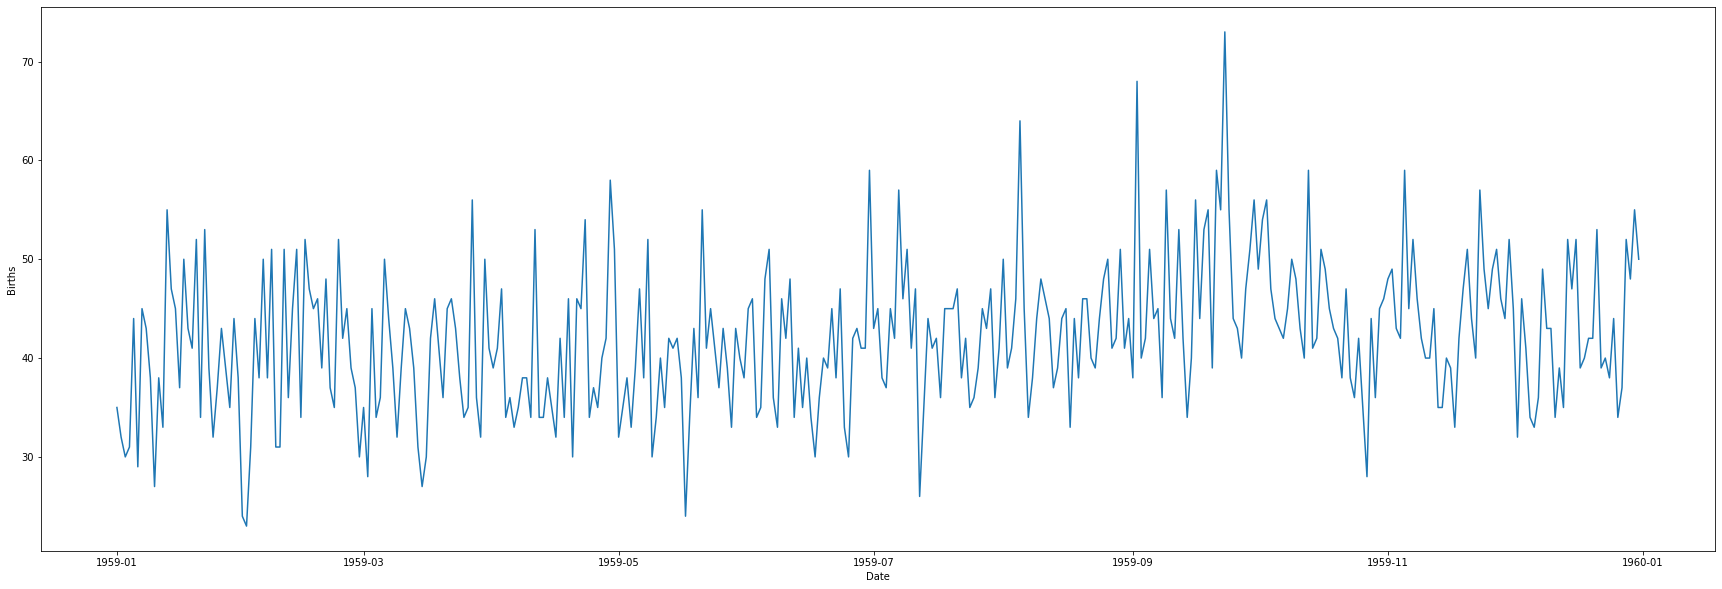

In [11]:
plt.figure(figsize=(30, 10))
sns.lineplot(data=df, x=date_time, y='Births')

There could be a pattern, but it feels more like an up and down, maybe random but doesn't seem to be the complete case

And now by day of the week

<AxesSubplot:xlabel='DayOfWeek', ylabel='Births'>

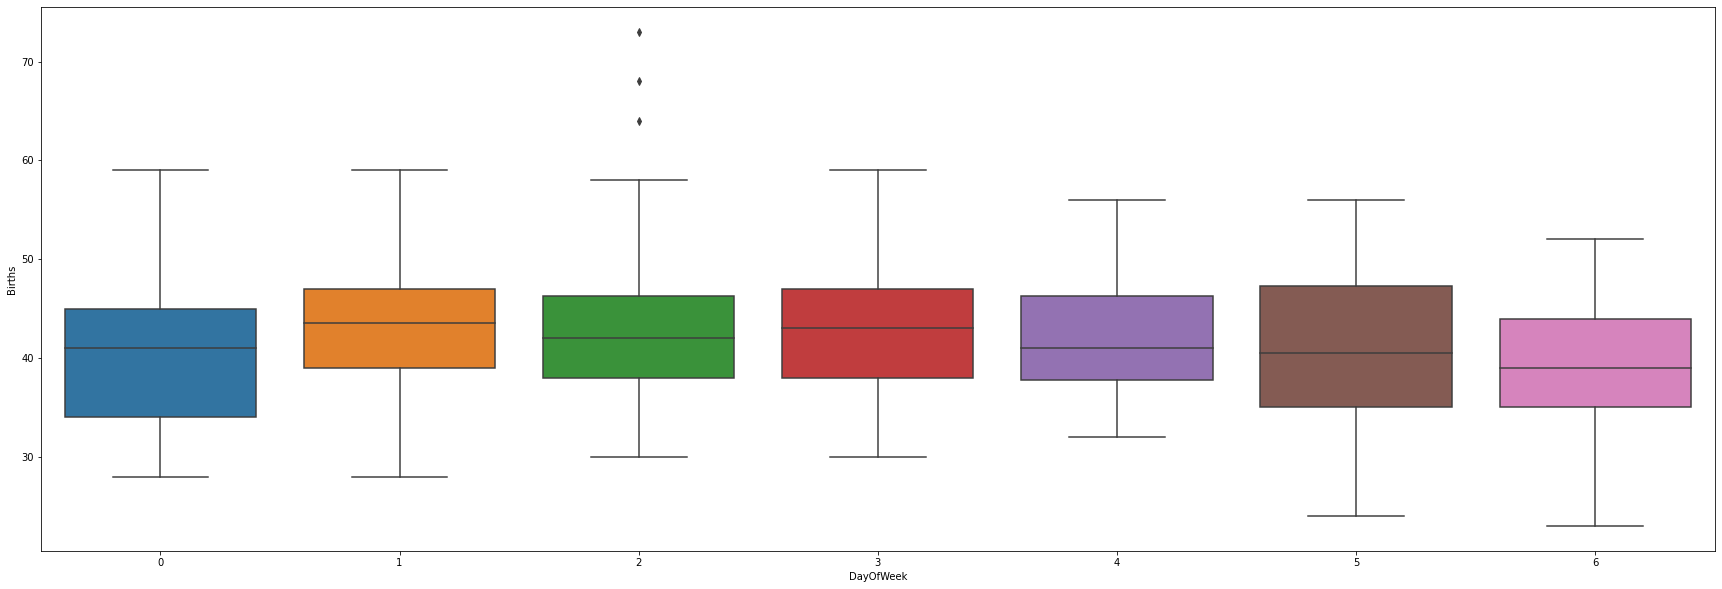

In [12]:
plt.figure(figsize=(30, 10))
sns.boxplot(data=df, x='DayOfWeek', y='Births')

### Correlation

How related two values are statistically speaking, and how much do they actually contribute to the dependant variable prediction

<AxesSubplot:>

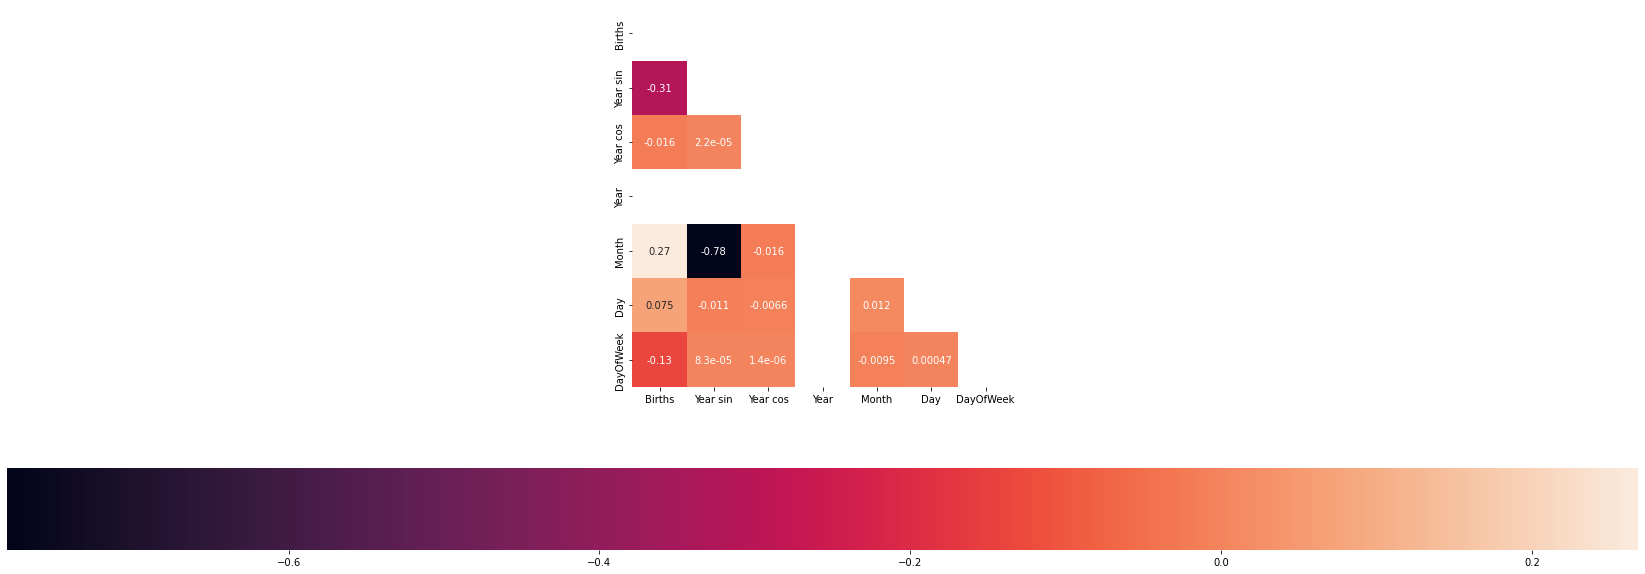

In [13]:
correlation = df.corr()
matrix = np.triu(correlation)
plt.figure(figsize=(30, 10))
sns.heatmap(correlation, mask=matrix, annot=True, cbar=True, cbar_kws={ 'orientation': 'horizontal' }, square=True)

### Data distribution

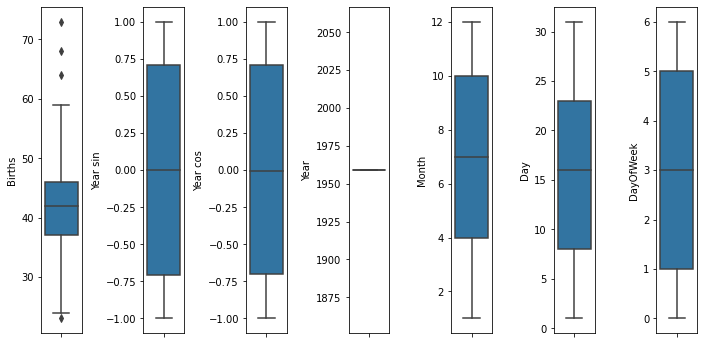

In [14]:
fig, axes = plt.subplots(1, df.shape[1], figsize=(10, 5))
axes.flatten()
for index, col in enumerate(df.columns):
  sns.boxplot(data=df, y=col, ax=axes[index])
plt.tight_layout(pad=1.5, w_pad=1.0, h_pad=1.0)

## Data science

The last touches before jumping into the model

### Splitting

We'll have to do a manual splitting since we're working with values that need to follow a chronological order

In [15]:
df_train = df[:int(len(df) * 0.75)]
df_val = df[int(len(df) * 0.75):int(len(df) * 0.90)]
df_test = df[int(len(df) * 0.90):]

Let's inspect the new rows distribution

In [16]:
('train', df_train.shape[0]), ('val', df_val.shape[0]), ('test', df_test.shape[0])

(('train', 273), ('val', 55), ('test', 37))

### Normalization

In [17]:
df_mean = df_train.mean()
df_std = df_train.std()

df_train = (df_train - df_mean) / df_std
df_val = (df_val - df_mean) / df_std
df_test = (df_test - df_mean) / df_std

## Time series

Something I've been wanting to try out: https://unit8co.github.io/darts/ (sadly, it doesn't properly work on Google Colab).

Using kats, from: https://www.analyticsvidhya.com/blog/2022/05/5-python-libraries-for-time-series-analysis/

### Installation

We'll need to "manually" install it

In [18]:
!pip install kats -q

### Imports

In [19]:
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

### Dataframe preparation

In [20]:

df['Date'] = pd.to_datetime(dataframe['Date'],infer_datetime_format=True,format='%y%m%d')
df_s = TimeSeriesData(time=df['Date'], value=df['Births'])
len(df_s)

365

### Model

The estimator it's straight from FacebookProphet, so you can quickly set up your environment

In [21]:
params = ProphetParams(seasonality_mode='multiplicative', yearly_seasonality=True)
model = ProphetModel(df_s, params)

model.fit()

forecast = model.predict(steps=30, freq="d")
forecast.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,time,fcst,fcst_lower,fcst_upper
0,1960-01-01,49.294189,40.963349,57.788857
1,1960-01-02,49.440396,40.865219,58.171096
2,1960-01-03,47.517100,39.096500,55.019708
3,1960-01-04,51.040671,42.559931,59.750181
4,1960-01-05,54.482093,45.571622,62.954132


### Visualizations

We can actually plot the forecasted values

<AxesSubplot:xlabel='time', ylabel='y'>

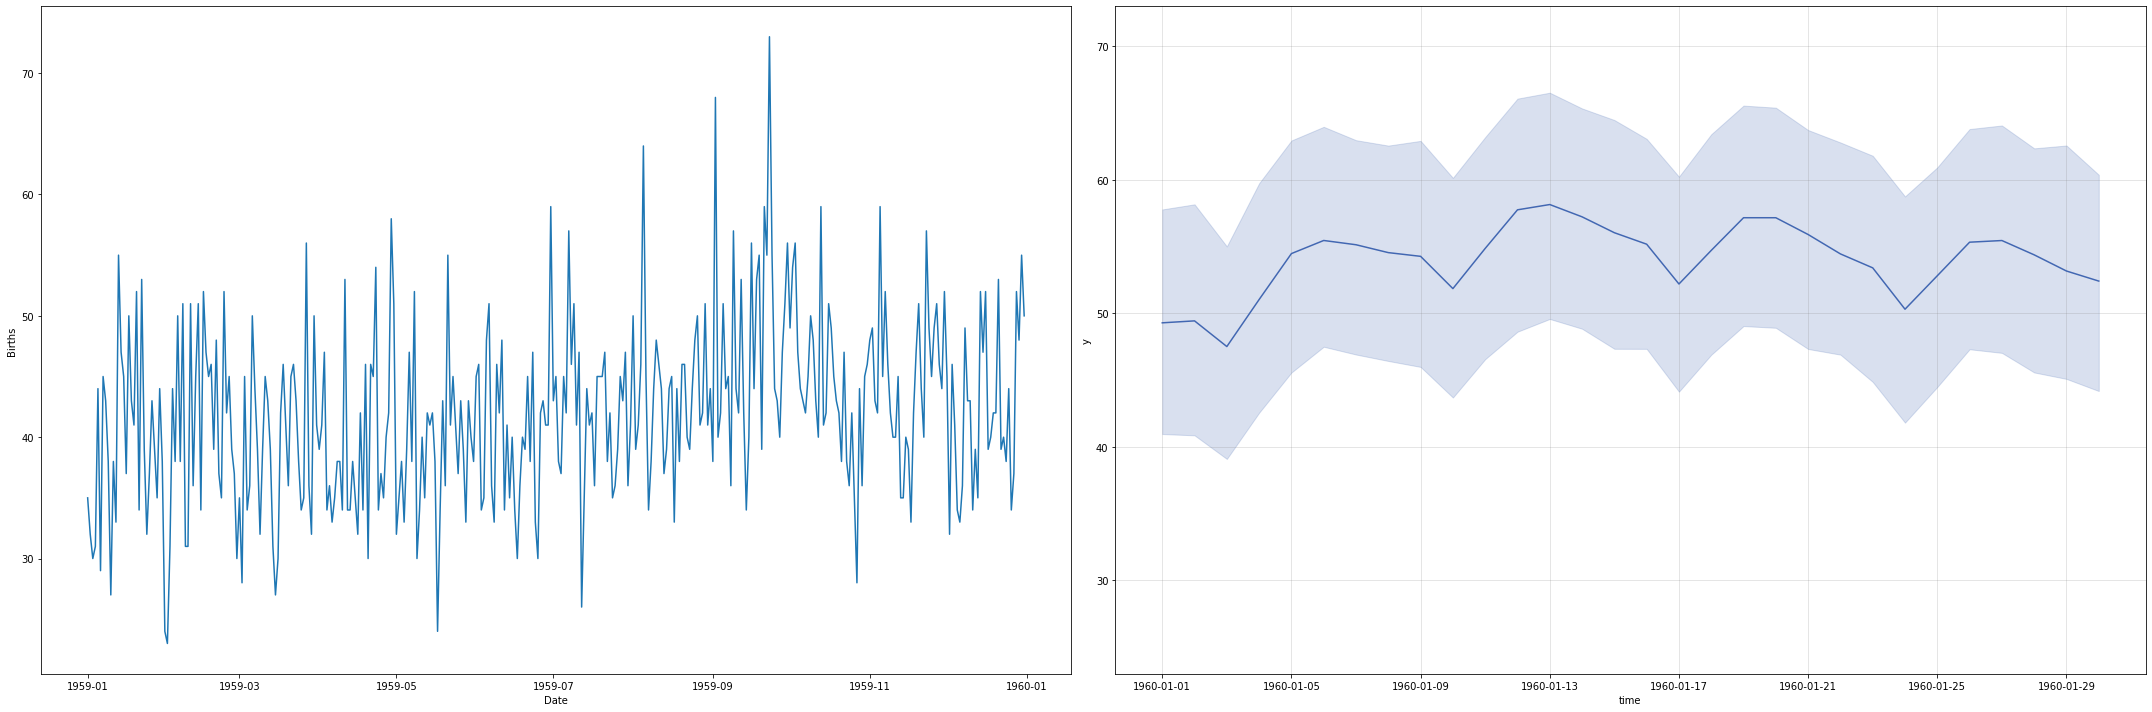

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

sns.lineplot(data=df, x=date_time, y='Births', ax=axes[0])

axes[1].set_ylim(df.Births.min(), df.Births.max())
model.plot(ax=axes[1])

### And now... with Tensorflow and Keras

Straight from: https://towardsdatascience.com/time-series-forecasting-using-tensorflow-and-deep-hybrid-learning-5088ad76dd55

In [23]:
import tensorflow as tf

# Convert the data values to numpy for better and faster processing
time_index = np.array(df['Date']) 
data = np.array(df['Births'])   
# Certain Hyper-parameters to tune
SPLIT_RATIO = 0.8
WINDOW_SIZE = 32
BATCH_SIZE = 32 
SHUFFLE_BUFFER = 1000  
# Dividing into train-test split
split_index = int(SPLIT_RATIO * data.shape[0])   
# Train-Test Split 
train_data = data[:split_index] 
train_time = time_index[:split_index]  
test_data = data[split_index:] 
test_time = time_index[split_index:]

In [24]:
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
  '''
  Utility function for time series data generation in batches
  '''
  ts_data = tf.data.Dataset.from_tensor_slices(data)
  ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
  ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
  ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  ts_data = ts_data.batch(batch_size).prefetch(1)
  return ts_data# Expanding data into tensors
tensor_train_data = tf.expand_dims(train_data, axis=-1)
tensor_test_data = tf.expand_dims(test_data, axis=-1)

In [25]:
tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_test_dataset = ts_data_generator(tensor_test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

In [26]:
# DHL Fusion model of 1D CNN and LSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(
    # filters=64,
    filters=128,
    # kernel_size=5,
    kernel_size=2,
    strides=1,
    padding="causal",
    activation="relu",
    input_shape=[None, 1],
  ),
  # tf.keras.layers.LSTM(64, return_sequences=True),
  # tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1)
])

# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(tensor_train_dataset, epochs=200, validation_data=tensor_test_dataset, verbose=0)
model.evaluate(tensor_test_dataset)

2/2 [==============================] - 0s 30ms/step - loss: 6.4573 - mae: 6.9429


[6.45734977722168, 6.942941188812256]

In [27]:
def model_forecast(model, data, window_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
    
rnn_forecast = model_forecast(model, data[..., np.newaxis], WINDOW_SIZE)
rnn_forecast = rnn_forecast[split_index - WINDOW_SIZE:-1, -1, 0]# Overall Error
error = tf.keras.metrics.mean_absolute_error(test_data, rnn_forecast).numpy()
print(error)

5.588251


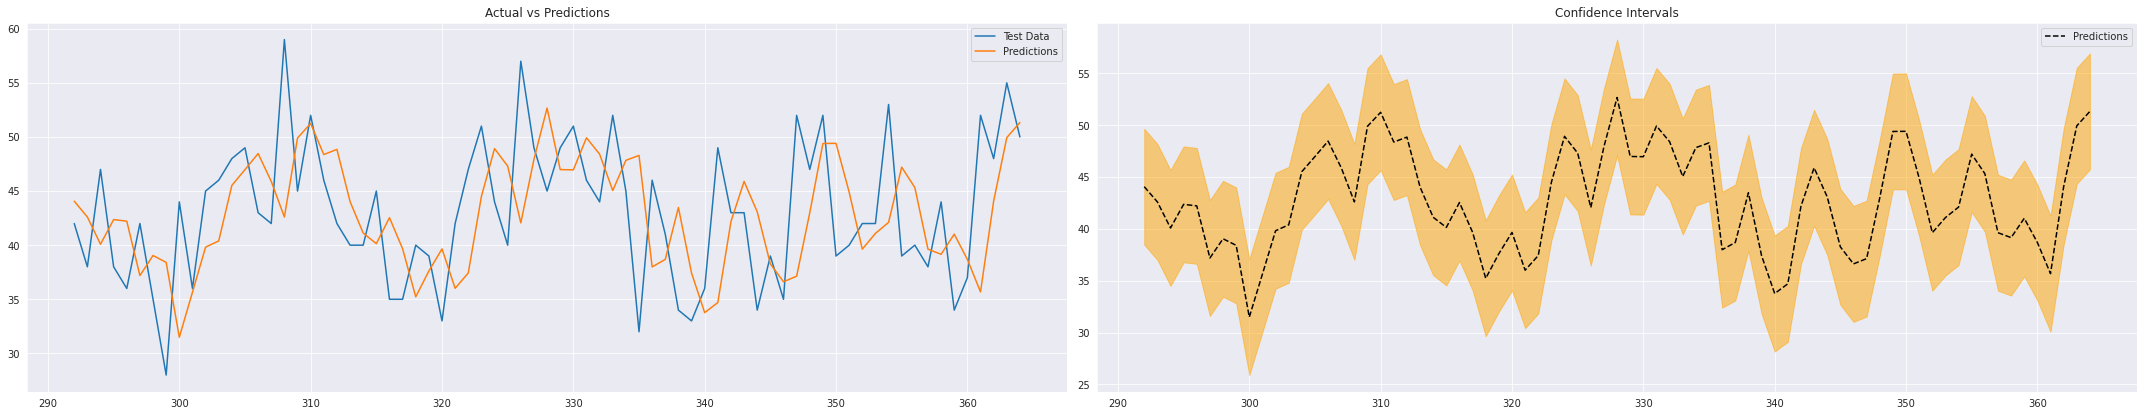

In [28]:
sns.set_style('darkgrid')

fig, axes = plt.subplots(1, 2, figsize=(30, 6))
axes[0].plot(list(range(split_index,len(data))), test_data, label = 'Test Data')
axes[0].plot(list(range(split_index,len(data))), rnn_forecast, label = 'Predictions')
axes[0].legend()
axes[0].set_title('Actual vs Predictions')

axes[1].plot(list(range(split_index,len(data))), rnn_forecast, label = 'Predictions', color = 'k', linestyle = '--')
axes[1].fill_between(range(split_index,len(data)), rnn_forecast - error, rnn_forecast + error, alpha = 0.5, color = 'orange')
axes[1].legend()
axes[1].set_title('Confidence Intervals')

plt.tight_layout(pad=1.5, w_pad=1.0, h_pad=1.0)